In [1]:
import numpy as np
%pylab inline
%load_ext autoreload
%autoreload 2
%precision 3

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.metrics.pairwise import pairwise_kernels
from itertools import chain, product
from sklearn.datasets import make_blobs
from scipy.optimize import check_grad, approx_fprime, minimize
import scipy as sp
import itertools

## Preparing some data to test

In [3]:
## making some data
np.random.seed(4)
n, d = 300, 2
mk, K = 4, 2
X, y = make_blobs(n, d, K, shuffle= True)
EPS = 1e-6

In [4]:
## randomly initialize initial solutions for optimisation
def choose_A0(X, y, m, K):
    idxs = []
    for k in range(K):
        idxs.append(np.random.choice(np.where(y == k)[0], m // K, replace = False))
    A0 = X[np.concatenate(idxs)]
    A0 = A0 + np.random.normal(size = A0.shape)
    return A0

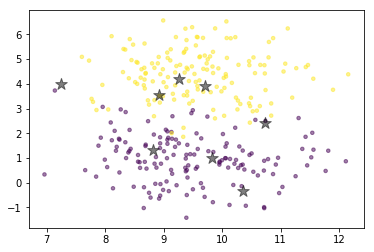

In [5]:
m = mk * K
A0 = choose_A0(X, y, m, K)
plt.scatter(X[:, 0], X[:, 1], c = y, marker = ".", alpha = 0.5, s = 50)
plt.scatter(A0[:, 0], A0[:, 1], c = "k", marker = "*", alpha = 0.5, s = 150)

## testing mmd-diff-greedy

In [6]:
import grad, subm, utils

## subm.py
`subm.py` has several functions that can be optimised greedily and several othet utility classes and functions:
1. `DelF`: abstract class for $F(S+s) - F(S)$, i.e. discrete derivative. Discrete derviatives can be combined linearly, i.e. G(S+s)-G(S) = F(S+s) - F(S) + H(S+s) - H(S)
2. `greedy_maximize_labels`: to optimise utility functions, e.g. F(S) which also take labels info.
3. `MMD`: $-MMD^2(\bar X_g, X_g)$
4. `Dummy`: Dummy utility function that does nothing
5. `EKxs`: $\mathbb{E}_{\bar x, x} k(\bar x, x)$, i.e. coverage term from expanded MMD equation (diversity term is removed)
6. `Div`: $-\mathbb{E}_{\bar x, \bar x^{'}k(\bar x, \bar x^{'})}$, i.e. diversity term from expanded MMD equation (coverage removed)
7. `Kxs`: coverage term without normalisation
8. `NNSubm`: Nearest neighbor submodular [see this](http://proceedings.mlr.press/v37/wei15.html)
9. `Critic`: The critic term from [MMD-Critic paper](http://papers.nips.cc/paper/6300-examples-are-not-enough-learn-to-criticize-criticism-for-interpretability.pdf)
10. `LogDet`: The Log of determinant if kernel submatrix, [see MMD-critic paper](http://papers.nips.cc/paper/6300-examples-are-not-enough-learn-to-criticize-criticism-for-interpretability.pdf)

If we don't want labels info while greedily maximising, we can use `greedy_maximize` method of class `DelF`.

### 1.MMD-diff
$\mathcal{U}_{diff}(\bar X) = \sum_g{-MMD^2(\bar X_g, X_g) + MMD^2(\bar X_g, X_{\not g})}$
for `MMD-div-greedy` use `- 1.0 * subm.EKxs()` as second argument to the function `greedy_maximize_labels`.

In [16]:
K_mat = utils.Kernel.create(X, metric = 'rbf', gamma = 0.5)
sol_greedy = subm.greedy_maximize_labels(subm.MMD(), - 1.0 * subm.MMD(), 
                                         V = np.arange(len(X)), y = y, k = 4, lambdaa=0.1,
                                         delF_args = {"K": K_mat}, delG_args = {"K": K_mat})
protos = itertools.chain(*sol_greedy.values())

*

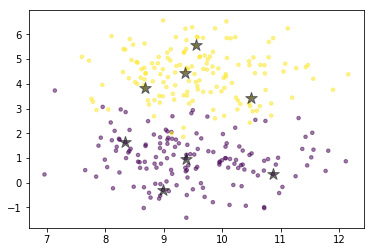

In [17]:
protos = list(protos)
plt.scatter(X[:, 0], X[:, 1], c = y, marker = ".", alpha = 0.5, s = 50)
plt.scatter(X[protos, :][:, 0], X[protos, :][:, 1], c = "k", marker = "*", alpha = 0.5, s = 150)

## testing MMD-diff-grad
for `mmd-div-grad`, use `EKxs` as 6th args while calling optimizer.

`grad.py` has several functions related to continuous optimisation of MMD objectives for comparative summarisation.
1. `ekxs_cost_grad`: cost and gradient of coverate term in MMD
2. `mmd_cost_grad`: cost and gradient of MMD objective
3. `mmd_cost_grad_labels`: cost and gradient of MMD with labels info, i.e. `mmd-diff-grad`, use `diff=EKxs` `mmd-div-grad`
4. `mmd_cost_grad_params`: cost and grad of `mmd-params-grad`, i.e. the comparativeness is calculated by MMD between prototypes of $g$ and $\not g$
5. There are other functions `step_decay`, `gd`, `sgd`, which is for GD and SGD optimisation of these utility functions.
6. There are non-gradient versions of functions in 1,2,3 and 4; which can be used to just check utility cost without computing gradients.

In [21]:
%%time
gamma,lambda_=0.5,0.1
opt_mmd_data = sp.optimize.minimize(grad.mmd_cost_grad_labels, A0.flatten(), 
                                args = (X, y, gamma, gamma, lambda_, "data"), 
                                method='L-BFGS-B', jac = True, tol = 1e-8,
                                options={'maxiter': 1000, 'disp': False})

CPU times: user 84.3 ms, sys: 1.41 ms, total: 85.7 ms
Wall time: 85.7 ms


In [22]:
A_mmd_data = opt_mmd_data.x.reshape(m, d)

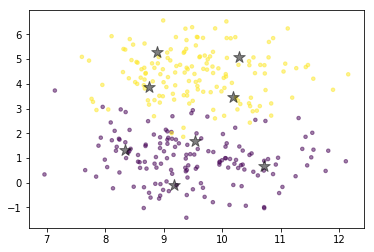

In [23]:
plt.scatter(X[:, 0], X[:, 1], c = y, marker = ".", alpha = 0.5, s = 50)
plt.scatter(A_mmd_data[:, 0], A_mmd_data[:, 1], c = "k", marker = "*", alpha = 0.5, s = 150)